In [2]:
%run util.py

<br>
<center><h1>Online Shopping Reivew Clustering</h1></center>
<br>
<center>쿠팡 피지오겔 데일리 모이스쳐 테라피 페이셜 크림 상품평</center>

<center><h5>최영록</h5></center>
<br>

<img src="../image/coupang_physiogel.png" alt="Drawing" style="width: 700px;"/>

<br>
# Dataset Introduction

* 쿠팡 피지오겔 데일리 모이스쳐 테라피 크림 상품평 7천 여개 중 텍스트가 기입된 3072개 리뷰 (2017.08.07 기준)
* 라벨링 되어있지 않는 한글 텍스트 리뷰로 Unsupervised Labeling
* Table Scheme: <b>UID | Text</b> 
* Target Page: http://www.coupang.com/vp/products/2801591?itemId=14692254&vendorItemId=3002041112&q=%ED%94%BC%EC%A7%80%EC%98%A4%EA%B2%94&itemsCount=36&searchId=ee1019efae944258a48975076025397a&rank=0

In [3]:
# file path
PATH = '../dataset/physiogel.csv'
df0 = pd.read_csv(PATH)
df00 = df0.dropna(subset=['text'])
temp = [x.strip().decode('utf-8') for x in df00['text'].values] # erase back and foward spaces/ decoding to unicode 
df = pd.DataFrame(data=temp, index=df00['uid'], columns=['text'])
df.head(10)

,text
uid,
28618460,매번 사용하는 제품인데 저렴하게 잘 삿습니당
28608506,몇 년째 쓰는 제품이예요~\n다른 기초화장품 없이 피지오겔크링과 선크림으로\n피부가...
28584972,조금 기름진느낌이 없지않아있어요
28584914,가격부담이 되도 계속 쓰고 있는 피지오겔 크림\n귀찮을때 이거 하나만 바르고 자도 ...
28581673,촉촉해서 수분크림대신바르는데 좋아요
28567308,배송빨라 좋네요
28542147,"1. 배송 : 로켓 아니어도 괜찬은데, 다음날 바로 도착헸네요. 배송기사님 감사합니..."
28465156,피지오겔~7년째사용중~~
28463679,항상 쓰던 제품입니다 좋아요~~


* 3072개 텍스트 파트 corpus로 활용

In [4]:
corpus = df.text.values
corpus.shape

(3072,)

<br>
* 리뷰 텍스트 길이

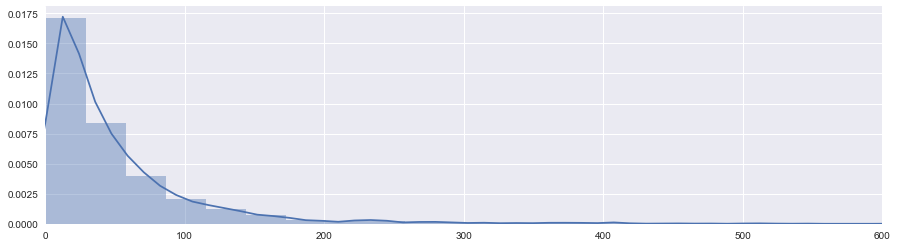

In [5]:
plt.figure(figsize=(15, 4))
plt.xlim(0, 600)
sns.distplot([len(x) for x in corpus])
plt.show()

<br>
# 프로젝트 목표

* Doc2Vec/ LDA/ K-means/ Hierachical Clustering 등 비지도적 클러스터링 알고리즘을 활용한 텍스트 군집화
* 클러스터링 기법을 활용한 Application 사용성 증대 및 배송, 가격, 품질, 포장 등 제품의 다양한 측면 인사이트 발굴
* 한글 텍스트 데이터 전처리 및 자연어 분석 능력 고도화

<br>
# 사용 패키지 소개

In [6]:
# Preprocessing
import numpy as np
import pandas as pd
import random
from konlpy.utils import pprint
from konlpy.tag import *

# Visualization
import matplotlib.pylab as plt
import seaborn as sns

# scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, k_means_, DBSCAN, AgglomerativeClustering
from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_distances

# hdbscan
import hdbscan

# gensim
from gensim import models
from gensim.corpora import mmcorpus, Dictionary
from gensim.models import lsimodel, ldamodel, tfidfmodel, rpmodel, logentropy_model, TfidfModel, LsiModel, LdaModel
from gensim import matutils, corpora
from gensim.models.doc2vec import TaggedDocument
from gensim.models import doc2vec
from gensim.models.word2vec import Word2Vec

<br>
<br>
# Preprocessing

* ### 형태소 분석

konlpy Twitter 형태소 분석기를 활용한 '명사', '형용사', '동사'를 추출하는 Tokenizer

In [7]:
def nav_tokenizer(corpus):
    twitter = Twitter()
    pos = twitter.pos(corpus)
    res = [x[0] for x in pos if (x[1] == u'Noun' or x[1] == u'Adjective' or x[1] == u'Verb')]
    return res

<br>
Stopwords를 분석 차원에서 제거하기 위한 함수 

In [8]:
def remove_stopwords(words, stopwords):
    res = [x for x in words if x not in stopwords]
    return res

<br>
빈출 단어 확인

In [9]:
vect0 = CountVectorizer(tokenizer=nav_tokenizer).fit(corpus)
temp = pd.DataFrame(vect0.vocabulary_.keys(), columns=['word'])
temp['idx'] = vect0.vocabulary_.values()
temp.sort_values(by='idx', inplace=True)
temp.drop('idx', axis=1, inplace=True)
temp['count'] = vect0.transform(corpus).toarray().sum(axis=0)
temp.sort_values(['count'], ascending=False).head(10)

,word,count
4170,좋,1893
690,피부,828
1149,피,725
3764,겔,701
3308,쓰,696
2352,보습,510
3874,크림,502
3707,제품,497
3114,바르,395
688,배송,388


<br>
빈출 단어 제거  
> 제품과 직접 관련이 있거나 너무 많은 빈도로 쓰인 상위 단어 제거

In [10]:
stopwords = [u'좋', u'피부', u'겔', u'피', u'쓰', u'크림']

In [11]:
vect = TfidfVectorizer(tokenizer=nav_tokenizer, stop_words=stopwords)
vect.fit(corpus)
print("token n/a/v: %d" % len(vect.vocabulary_))

token n/a/v: 4793


<br>
1단어 어휘 중 Tokenizer의 성능으로 인해 무의미하게 수집된 어휘 제거

In [12]:
# '입, 뺨, 향, 손, 떡, 몇, 봄, 딸, 집, 코, 양, 년, 늘' 을 제외한 1단어 명사 명사 벡터 Stopwords에 추가
mask1 = [x for x in vect.vocabulary_ if len(x) == 1]
mask1 = [x for x in mask1 if x not in [u'입', u'뺨', u'향', u'손', u'떡', u'몇', u'봄', u'딸', u'집', u'코', u'양', u'년', u'좋', u'늘']]
len(mask1)

579

In [13]:
vect = TfidfVectorizer(tokenizer=nav_tokenizer, stop_words=stopwords + mask1)
vect.fit(corpus)
print("token n/a/v: %d" % len(vect.vocabulary_))

token n/a/v: 4214


In [14]:
# corpus array for scikit-learn package
X = vect.transform(corpus).toarray()

<br>
# LDA (Latent Dirichlet Allocation)

each document may be viewed as a mixture of various topics where each document is considered to have a set of topics that are assigned to it via LDA.

<img src="../image/latent_dirichlet_allocation.png" alt="Drawing" style="width: 300px;"/>

<br>

In [15]:
lda_docs = [nav_tokenizer(x) for x in corpus]
lda_docs = [remove_stopwords(x, stopwords + mask1) for x in lda_docs]
lda_dict = corpora.Dictionary(lda_docs)

In [16]:
#calulate TF-IDF
tf_ps = [lda_dict.doc2bow(x) for x in lda_docs]
tf_model = models.TfidfModel(tf_ps)
X_lda = tf_model[tf_ps]
corpora.MmCorpus.serialize('ps.mm', X_lda)

<br>
* 10개 주제 모델링

In [17]:
# train topic model
ntopics =10
nwords = 5

In [18]:
# LDA
np.random.seed(1)
lda = models.ldamodel.LdaModel(X_lda, id2word=lda_dict, num_topics=ntopics)
pprint(lda.print_topics(num_topics=ntopics, num_words=nwords))

[(0,
  0.022*"빠르" + 0.022*"배송" + 0.018*"늘" + 0.011*"제품" + 0.011*"입니"),
 (1,
  0.010*"제품" + 0.010*"정말" + 0.009*"배송" + 0.009*"필요없" + 0.007*"보습"),
 (2,
  0.014*"아기" + 0.010*"애기" + 0.009*"발라" + 0.008*"우리" + 0.008*"배송"),
 (3,
  0.019*"저렴" + 0.016*"하게" + 0.014*"싸게" + 0.011*"배송" + 0.010*"빠르"),
 (4,
  0.015*"보습" + 0.013*"최고" + 0.008*"믿고" + 0.007*"입니" + 0.007*"사용하고"),
 (5,
  0.029*"너무" + 0.019*"쓰는" + 0.015*"촉촉하니" + 0.010*"보습" + 0.009*"항상"),
 (6,
  0.032*"보습" + 0.026*"역시" + 0.010*"굿굿" + 0.007*"쫀쫀" + 0.005*"말할"),
 (7,
  0.010*"받았" + 0.007*"포장" + 0.007*"상태" + 0.007*"역시" + 0.007*"순해서"),
 (8,
  0.019*"항상" + 0.010*"만족합" + 0.010*"구매" + 0.009*"순하고" + 0.008*"완전"),
 (9,
  0.014*"촉촉하고" + 0.011*"건성" + 0.009*"부드럽" + 0.008*"겨울" + 0.008*"있어")]


<br>
* Probability 0.3 수준에서 라벨링 테이블 작성

In [19]:
dfRes = pd.DataFrame(corpus, columns=['text'])
for i in range(10):
    dfRes[i] = 0; 
dfRes['unknown'] = 0
    
for i in range(len(tf_ps)):
    temp = get_labels(lda, 0.3, tf_ps[i])
    if temp != None:
        idx = [x[0] for x in temp]
        dfRes.set_value(i, idx, 1)
    elif temp == None:
        dfRes.set_value(i, ['unknown'], 1)

In [20]:
# number of reviews for each label
for i in range(10):
    print('label({}): {}'.format(i, len(dfRes[(dfRes[i] == 1)])))
print('unknown: {}'.format(len(dfRes[(dfRes['unknown'] == 1)])))

label(0): 432
label(1): 376
label(2): 434
label(3): 359
label(4): 345
label(5): 262
label(6): 235
label(7): 139
label(8): 477
label(9): 276
unknown: 237


<br>
* <b>라벨 0:</b> (빠르 + 배송 + 늘 + 제품 + 입니) 

In [21]:
dfRes[dfRes[0] == 1].head(7)

,text,0,1,2,3,4,5,6,7,8,9,unknown
8,항상 쓰던 제품입니다 좋아요~~,1,0,0,0,0,0,0,0,0,0,0
9,배송도 빠르고 좋으네영,1,0,0,0,0,0,0,0,0,0,0
15,촉촉해요~~!!,1,0,0,0,0,0,0,0,0,0,0
29,늘 쓰던거라 믿고 구매합니다,1,0,0,0,0,0,0,0,0,0,0
47,매번 쓰는 인생 크림입니다. 저렴하게 잘샀어요. 배송도 빠르고 감사합니다.,1,0,0,0,0,0,0,0,0,0,0
49,이제품만씁니다,1,0,0,0,0,0,0,0,0,0,0
51,너무나 유명한 피지오겔 제품입니다. 피부 건조증을 한번에 해결합니다.,1,0,0,0,0,0,0,0,0,0,0


<br>
* <b>라벨 2:</b> (아기 + 애기 + 발라 + 우리 + 배송) 

In [22]:
dfRes[dfRes[1] == 1].head(7)

,text,0,1,2,3,4,5,6,7,8,9,unknown
14,좋아요 여름엔 좀 끈적거러요^^,0,1,0,0,0,0,0,0,0,0,0
16,계속 구매해서 쓰고 있습니다. 이만한 수분크림은 본적이 없어요~,0,1,0,0,0,0,0,0,0,0,0
21,"초1아들이 땀이 많아 땀띠가심해서, 병원에서 보습제 많이 발라주라해서 구입했어요. ...",0,1,0,0,0,0,0,0,0,0,0
26,첫째부터 둘째까지 어린아이를 위해 여름에도 그름만 사용하네요 \n끈적임없고 흠수 ...,0,1,0,0,0,0,0,0,0,0,0
37,워낙 유명해서\n계속 쓰고 있는 제품입니다\n제가 기초를 바꾸면\n트러블이 나는데\...,0,1,0,0,0,0,1,0,0,0,0
40,굿궇\n\n항상써요^^,0,1,0,0,0,0,0,0,0,0,0
41,아기발라주려고사봤어여 그런데 다른제품쓰느라 이걸 제가썼더니\n제 타입은 매우 건조한...,0,1,1,0,0,0,0,0,0,0,0


<br>
* <b>라벨 3:</b> (저렴 + 하게 + 싸게 + 배송 + 빠르) 

In [23]:
dfRes[dfRes[3] == 1].head(7)

,text,0,1,2,3,4,5,6,7,8,9,unknown
0,매번 사용하는 제품인데 저렴하게 잘 삿습니당,0,0,0,1,0,0,0,0,0,0,0
7,피지오겔~7년째사용중~~,0,0,0,1,0,0,0,0,0,0,0
19,배송 및 상품 만족스럽습니다.,0,0,0,1,0,0,1,0,0,0,0
24,늘 쓰는 제품이에요. 쿠팡에서 저렴하게 잘 구입했어요.,0,0,0,1,0,0,0,0,0,0,0
53,많이 파세요,0,0,0,1,0,0,0,0,0,0,0
68,괜찮아요~0,0,0,0,1,0,0,0,0,0,0,0
83,늘 쓰던거라 구매합니다\n하나만써도 크게 무리가 없어요\n가격도 좋은 편이었어요,0,0,0,1,0,0,0,0,0,0,0


<br>
* <b>라벨이 부여되지 않은 리뷰</b>

In [24]:
dfRes[dfRes['unknown'] == 1].head(7)

,text,0,1,2,3,4,5,6,7,8,9,unknown
10,좋네요,0,0,0,0,0,0,0,0,0,0,1
13,좋습니다,0,0,0,0,0,0,0,0,0,0,1
20,좋아요,0,0,0,0,0,0,0,0,0,0,1
43,지인 추천으로 쓰게된 화장품이에용\n\n아직 몇 번 사용하지 않아 잘 모르지만\n\...,0,0,0,0,0,0,0,0,0,0,1
56,태열에 침독에 약한 아토피기가 있는아기라 크림은 거의 정류별로 다써봤어요\n이제 거...,0,0,0,0,0,0,0,0,0,0,1
62,좋아요,0,0,0,0,0,0,0,0,0,0,1
72,좋아요~~^^,0,0,0,0,0,0,0,0,0,0,1


### LDA 성능
* Treshold 수준을 조정함에 따라 중복을 허용하는 클러스터링 가능
* Document를 주제 단위로 클러스터링 가능 
* 비슷한 주제어를 가진 리뷰들끼리 클러스터링하나 완벽하지 않음

<br>
# Doc2Vec
Gensim 패키지의 Doc2Vec Embedding을 활용한 문서 클러스터링  
Word2Vec의 자연어 Embbeding을 Paragraph 단위로 적용하여 적은 차원으로 문서간의 관계를 타나냄

<div style="float:left; width: 50%;">
<img src="../image/d2v_model1.png" alt="Drawing" style="width: 500px;"/>
</div>

<div style="float:left; width: 50%;">
<img src="../image/d2v_model2.png" alt="Drawing" style="width: 500px;"/>
</div>

<p style="font-size:12px; text-align:center;">[2] Doc2Vec Model</p>

In [25]:
d2v_docs = [nav_tokenizer(x) for x in corpus]
d2v_docs = [remove_stopwords(x, (stopwords + mask1)) for x in d2v_docs]

In [26]:
tagged_d2v_docs = [TaggedDocument(doc, [idx]) for idx, doc in enumerate(d2v_docs)]

In [27]:
d2v_model = doc2vec.Doc2Vec(size=300, window=5, alpha=0.025, min_alpha=0.025, seed=0)
d2v_model.build_vocab(tagged_d2v_docs)
d2v_model.train_lbls = False # do not train labels of words
d2v_model.train_words = True # only train relations among words

In [28]:
for epoch in range(10):
    d2v_model.train(tagged_d2v_docs, total_examples=len(d2v_docs), epochs=epoch)
    d2v_model.alpha -= 0.002 # decrease the learning rate
    d2v_model.min_alpha = d2v_model.alpha # fix the learning rate, no decay

<br>
* 유사 어휘 탐색

In [29]:
pprint(d2v_model.most_similar(u'항상'))

[(늘, 0.947917103767395),
 (믿고, 0.931358814239502),
 (지오, 0.8832617402076721),
 (역시, 0.8622429370880127),
 (쓰는, 0.850908100605011),
 (사는, 0.8503872752189636),
 (하려, 0.8430297374725342),
 (유명한, 0.8286793828010559),
 (사용하는, 0.815813422203064),
 (매번, 0.8107916712760925)]


In [30]:
len(d2v_model.wv.vocab)

895

In [31]:
X_d2v = [d2v_model.infer_vector(x.words) for x in tagged_d2v_docs]

<br>
* 유사 문장 탐색

In [32]:
idx = 5
pprint('review: '+ corpus[idx])
print("")
for x in d2v_model.docvecs.most_similar(positive=[X_d2v[idx]]):
    pprint(corpus[x[0]] + ' (%3f)' % x[1])

review: 배송빨라 좋네요

역시 촉촉해요 (0.974999)
촉촉해요~ 가격이 좀 더 착했음 바람이~^^ (0.972537)
너무 촉촉해요 좋아요~ (0.971971)
역시 촉촉!!
선물하려고 샀습니다 (0.970107)
굿굿 촉촉해요 (0.969885)
말로만듣다가 진짜좋네요 (0.969052)
항상쓰던거라
촉촉해요 (0.968999)
엄청 촉촉해요..애들도.. 어른도 써요^^ (0.968497)
촉촉하니 너무좋아요~ (0.968176)
과연 소문대로 촉촉하고 좋아요 (0.965846)


> 배송 관련 리뷰에 근접하지 않은 인접 문장들이 출력

In [33]:
idx = 121
pprint('review: '+ corpus[idx])
print("")
for x in d2v_model.docvecs.most_similar(positive=[X_d2v[idx]]):
    pprint(corpus[x[0]] + ' (%3f)' % x[1])

review: 항상 이용합니다. 너무 좋아요

촉촉하고 너무좋아요 보습짱 (0.760921)
너무 촉촉하고 좋아요 쵝오 (0.756269)
피부도 촉촉하고 건조해진 요즘 쓰기 딱 좋아요 (0.755471)
로션보다 좋은것같아요
촉촉하고 좋아요 (0.755394)
건조할때 최고예요 (0.755156)
역쉬 겨울철엔 피지오겔..
촉촉하고 좋아요 (0.754173)
촉촉하고 맘에 들어요 
요즘 잘쓰고 있어요^^ (0.752125)
촉촉하고 부드러워요. (0.751897)
촉촉하고 보습좋아요 (0.751273)
피지오겔 크림 순하고촉촉해서 너무 좋아요! (0.750313)


> 항상 쓰는 제품 관련 리뷰는 비교적 잘 모임

* ### k-means w/ Doc2Vec

Doc2Vec 로 변환된 Corpus로 k-means 알고리즘 적용

In [34]:
cnum = 10

<br>
Centroid norm으로 cosine_distance 적용

In [35]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import k_means_ 

def euc2cos_distance(X, Y=None, Y_norm_squared=None, squared=False):
    return cosine_distances(X,Y)

k_means_.euclidean_distances = euc2cos_distance 

In [36]:
km = KMeans(n_clusters=cnum, init='k-means++', max_iter=300, n_init=20, tol=0.0001)
km.fit(X_d2v)
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_d2v, km.labels_))

Silhouette Coefficient: 0.108


In [37]:
dfRes = pd.DataFrame(corpus, columns=['text'])
dfRes['label'] = km.labels_

for i in range(cnum):
    print('label{}: {}'.format(i, len(dfRes[dfRes.label == i])))

label0: 659
label1: 543
label2: 47
label3: 235
label4: 569
label5: 93
label6: 1
label7: 370
label8: 479
label9: 76


<br>
클러스터별 상위 어휘 출력

In [38]:
# print top keywords
def print_topwords(df, num, bar):
    try:
        temp_cor = df.text.values
        temp_vec = TfidfVectorizer(tokenizer=nav_tokenizer, stop_words=stopwords + mask1)

        temp_vec.fit(temp_cor)

        temp = pd.DataFrame(temp_vec.vocabulary_.keys(), columns=['word'])
        temp['idx'] = temp_vec.vocabulary_.values()
        temp.sort_values(by='idx', inplace=True)
        temp['count'] = temp_vec.transform(temp_cor).toarray().sum(axis=0)

        topwords = temp.sort_values(['count'], ascending=False)[:num]    
    
        for i in range(num):
            print(topwords['word'].values[i]),

        if bar == True:
            fig, ax = plt.subplots()
            plt.bar(range(num), topwords['count'].values, align='center')
            plt.xticks([x for x in range(num)], topwords['word'].values)
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
            plt.tight_layout()
            plt.show()
        else:
            pass
    except:
        pass

In [39]:
for i in range(cnum):
    print('cluster {}:'.format(i)),
    print_topwords(df=dfRes.loc[dfRes['label'] == i], num=5, bar=False)
    print("")

cluster 0: 보습 아기 배송 촉촉하고 너무 
cluster 1: 역시 제품 배송 보습 너무 
cluster 2: 아기 발라 바르 사용 얼굴 
cluster 3: 배송 제품 빠르 구매 상품 
cluster 4: 보습 배송 너무 제품 바르 
cluster 5: 제품 바르 느낌 얼굴 같아 
cluster 6: 발라 로션 하루 구매 부분 
cluster 7: 아기 보습 발라 제품 얼굴 
cluster 8: 보습 제품 항상 배송 최고 
cluster 9: 제품 바르 보습 같아 얼굴 


<br>
* ### Agglomerative Clustering w/ doc2vec

In [40]:
cnum = 10

In [41]:
agg = AgglomerativeClustering(n_clusters=cnum, affinity='cosine', linkage='complete')
agg.fit(X_d2v)
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_d2v, agg.labels_))

Silhouette Coefficient: -0.009


In [42]:
dfRes = pd.DataFrame(corpus, columns=['text'])
dfRes['label'] = agg.labels_
for i in range(len(dfRes.label.unique())):
    print('label {}: {}'.format(i, len(dfRes.loc[dfRes['label'] == i])))

label 0: 135
label 1: 161
label 2: 1174
label 3: 72
label 4: 742
label 5: 18
label 6: 45
label 7: 68
label 8: 23
label 9: 634


In [43]:
for i in range(cnum):
    print('cluster {}:'.format(i)),
    print_topwords(df=dfRes.loc[dfRes['label'] == i], num=5, bar=False)
    print("")

cluster 0: 아기 발라 보습 냄새 얼굴 
cluster 1: 보습 제품 쓰는 아기 촉촉하고 
cluster 2: 보습 촉촉하고 배송 제품 너무 
cluster 3: 배송 보습 바르 촉촉함 제품 
cluster 4: 항상 배송 제품 역시 쓰는 
cluster 5: 발라 않고 바르 아기 아이 
cluster 6: 배송 빠르 받았 제품 로켓 
cluster 7: 너무 빠르 배송 입니 보습 
cluster 8: 제품 상품 배송 보습 년 
cluster 9: 보습 아기 제품 구매 배송 


<br>
* ### DBSCAN w/ doc2vec
Density-based Spatial Clustering of Aplications with Noise

<img src="../image/dbscan.png" alt="Drawing" style="width: 300px;"/>

<p style="font-size:12px; text-align:center;">[3] minPts = 4. Point A and the other red points are core points, because the area surrounding these points in an ε radius contain at least 4 points (including the point itself). Because they are all reachable from one another, they form a single cluster. Points B and C are not core points, but are reachable from A (via other core points) and thus belong to the cluster as well. Point N is a noise point that is neither a core point nor directly-reachable.</p>

In [44]:
db = DBSCAN(eps=0.1, min_samples=10, algorithm='brute', metric='cosine')
Y = db.fit_predict(X_d2v)

In [45]:
# Number of clusters in labels, ignoring noise if present.
cnum = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Estimated number of clusters: %d' % cnum)
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_d2v, db.labels_))

Estimated number of clusters: 3
Silhouette Coefficient: 0.007


In [46]:
dfRes = pd.DataFrame(corpus, columns=['text'])
dfRes['label'] = Y

In [47]:
for i in range(len(dfRes.label.unique())):
    if i == 0 :
        print('label -1: {}'.format(len(dfRes.loc[dfRes['label'] == i-1])))
    else:
        print('label {}: {}'.format(i-1, len(dfRes.loc[dfRes['label'] == i-1])))

label -1: 1183
label 0: 1664
label 1: 212
label 2: 13


In [48]:
for i in range(-1, cnum):
    print('cluster {}:'.format(i)),
    print_topwords(df=dfRes.loc[dfRes['label'] == i], num=5, bar=False)
    print("")

cluster -1: 보습 제품 배송 아기 바르 
cluster 0: 보습 배송 제품 항상 역시 
cluster 1: 
cluster 2: 보습 


<br>
동일한 단어로 구성된 리뷰 검출

In [49]:
dfRes[dfRes['label'] == 1].head(7)

,text,label
10,좋네요,1
13,좋습니다,1
20,좋아요,1
62,좋아요,1
72,좋아요~~^^,1
76,좋아요,1
89,피지오겔 좋아요,1


In [50]:
dfRes[dfRes['label'] == 2].head(7)

,text,label
66,보습력 좋네요.,2
259,보습력이 짱 좋아요,2
317,보습력이 넘 좋아요~,2
837,보습이 좋아요,2
979,보습에 좋음,2
1792,보습짱,2
1854,보습이 잘 되서 넘좋아요,2


<br>
* ### HDBSCAN Soft Clustering w/ Doc2Vec

하나의 리뷰에 여러개 주제가 함께 존재하는 샘플들을 클러스터링 하기 위해 HDBSCAN을 활용한 Soft Clustering 시도[4] 했으나 클러스터링 거의 되지 않음

In [51]:
cluster = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True).fit(X_d2v)

In [52]:
cnum = len(np.unique(cluster.labels_)) - 1
cnum

4

### Clustering w/ Doc2Vec 성능
* corpus내 단어들 간의 관계를 유추할 수 있음
* 문장간 유사도 판별 성능이 좋지 않음 -> 트레이닝 데이터 셋의 개수를 늘려서 다시 시도해볼 것
* 비슷한 주제어를 가진 리뷰들이 각각 여러개의 주제를 포함할 때 Partitioning 알고리즘과의 조합 성능 좋지 않음

<br>
# LDA + Doc2Vec

LDA를 통해서 추출한 포함된 주제별 유사도와 문서간 거리를 유사도를 측정할 수 있는 Doc2Vec Vector를 Concatenating

<br>
* LDA 모델링

In [53]:
lda_docs = [nav_tokenizer(x) for x in corpus]
lda_docs = [remove_stopwords(x, stopwords + mask1) for x in lda_docs]
lda_dict = corpora.Dictionary(lda_docs)
#calulate TF-IDF
tf_ps = [lda_dict.doc2bow(x) for x in lda_docs]
tf_model = models.TfidfModel(tf_ps)
X_lda = tf_model[tf_ps]

<br>
* 전체 corpus를 30개 주제로 세분화

In [54]:
# train topic model
ntopics = 30
nwords = 5

np.random.seed(1)
lda_model = models.ldamodel.LdaModel(X_lda, id2word=lda_dict, num_topics=ntopics)
pprint(lda_model.print_topics(num_topics=ntopics, num_words=nwords))

[(0,
  0.013*"잘산" + 0.011*"쵝오" + 0.009*"맞지" + 0.008*"필요할" + 0.008*"들어"),
 (1,
  0.018*"필요없" + 0.011*"제품" + 0.009*"갑자기" + 0.009*"항상" + 0.009*"바로"),
 (2,
  0.029*"만족합" + 0.016*"늘" + 0.014*"촉촉합" + 0.014*"제품" + 0.012*"아이"),
 (3,
  0.055*"빠르" + 0.047*"배송" + 0.037*"항상" + 0.019*"파세" + 0.012*"저렴"),
 (4,
  0.015*"받아" + 0.015*"로켓" + 0.013*"정말" + 0.012*"추천" + 0.010*"입니"),
 (5,
  0.047*"받았" + 0.029*"쓰는" + 0.019*"항상" + 0.015*"안해" + 0.012*"상품"),
 (6,
  0.060*"역시" + 0.013*"아들" + 0.011*"중이" + 0.011*"보습" + 0.010*"쿠팡"),
 (7,
  0.008*"바르" + 0.008*"모두" + 0.008*"나쁘" + 0.007*"촉촉해서" + 0.007*"전혀"),
 (8,
  0.024*"만족" + 0.019*"진리" + 0.012*"괜찮" + 0.011*"구매" + 0.009*"좋아지는"),
 (9,
  0.021*"애기" + 0.021*"강추" + 0.011*"발라" + 0.011*"아기" + 0.010*"우리"),
 (10,
  0.020*"있어" + 0.018*"부드럽" + 0.015*"정말" + 0.010*"보았" + 0.010*"감은"),
 (11,
  0.082*"보습" + 0.021*"건성" + 0.012*"필수품" + 0.010*"추천합" + 0.010*"처음"),
 (12,
  0.015*"보습" + 0.012*"효과" + 0.012*"종일" + 0.011*"그닥" + 0.009*"겨울철"),
 (13,
  0.027*"아주" + 0.023*"건조한" + 0.016*"제품" + 0

<br>
* 리뷰별 해당 주제 할당

In [55]:
idx = 11
pprint(corpus[idx])

바르고 30분이 지나서 얼굴을 보니 빨갛더라구요 너무 놀래서 씻고나서 리뷰를 보는데 참... 건성분들은 모르겠지만 중성 지성 분들은 사지마세요 저는 겨을에 바디로션 대신 바를려구요..^^


In [56]:
lda_model[X_lda[idx]]

[(4, 0.5366510509230179), (12, 0.18305400638005612), (15, 0.11207810570841419)]

<b>Topic 4:</b> 받아, 로켓, 정말, 추천, 입니  
<b>Topic 12:</b> 보습. 효과, 종일, 그닥, 겨울철  
<b>Topic 15:</b> 아기, 저렴, 쓰는, 선물, 항상

<br>
* LDA Vector 생성

In [57]:
lda_vec = np.zeros((len(corpus), ntopics))
lda_vec.shape

(3072, 30)

In [58]:
for i in range(len(lda_vec)):
    idx = [x[0] for x in lda_model[X_lda[i]]]
    prob = [x[1] for x in lda_model[X_lda[i]]]
    lda_vec[i][idx] = prob

/Users/choiyoungrok/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


In [59]:
# raise small number to calculate cosine distances
lda_vec = lda_vec + 0.0001

<br>
* doc2vec vector와 연결

In [60]:
X_l2v = np.hstack((X_d2v, lda_vec))

<br>
* ### k-means w/ LDA + Doc2Vec

In [61]:
cnum = 10

In [62]:
km = KMeans(n_clusters=cnum, init='k-means++', max_iter=300, n_init=20, tol=0.0001)
km.fit(X_l2v)
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_l2v, km.labels_))

Silhouette Coefficient: 0.163


In [63]:
dfRes = pd.DataFrame(corpus, columns=['text'])
dfRes['label'] = km.labels_

for i in range(cnum):
    print('label{}: {}'.format(i, len(dfRes[dfRes.label == i])))

label0: 1066
label1: 173
label2: 932
label3: 157
label4: 132
label5: 113
label6: 118
label7: 131
label8: 114
label9: 136


In [64]:
for i in range(cnum):
    print('cluster {}:'.format(i)),
    print_topwords(df=dfRes.loc[dfRes['label'] == i], num=5, bar=False)
    print("")

cluster 0: 제품 항상 보습 너무 배송 
cluster 1: 촉촉하고 최고 보습 입니 제품 
cluster 2: 배송 제품 보습 항상 쓰는 
cluster 3: 배송 정말 보습 로켓 같아 
cluster 4: 필요없 제품 발라 배송 보습 
cluster 5: 촉촉하니 순하고 저렴 하게 배송 
cluster 6: 구매 저렴 아기 제품 가격 
cluster 7: 역시 보습 구매 배송 쿠팡 
cluster 8: 배송 빠른 완전 감사합 너무 
cluster 9: 보습 건성 입니 아기 발라 


<br>
* ### DBSCAN w/ LDA + Doc2Vec

In [65]:
db = DBSCAN(eps=0.30, min_samples=10, algorithm='kd_tree', metric='euclidean')
Y = db.fit_predict(lda_vec)

In [66]:
# Number of clusters in labels, ignoring noise if present.
cnum = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Estimated number of clusters: %d' % cnum)
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_l2v, db.labels_))

Estimated number of clusters: 8
Silhouette Coefficient: 0.066


In [67]:
dfRes = pd.DataFrame(corpus, columns=['text'])
dfRes['label'] = Y

In [68]:
for i in range(len(dfRes.label.unique())):
    if i == 0 :
        print('noise-1: {}'.format(len(dfRes.loc[dfRes['label'] == i-1]))),
        print(" | "),
        print_topwords(df=dfRes.loc[dfRes['label'] == i-1], num=5, bar=False)
    else:
        print('cluster {}: {}'.format(i-1, len(dfRes.loc[dfRes['label'] == i-1]))),
        print(" | "),
        print_topwords(df=dfRes.loc[dfRes['label'] == i-1], num=5, bar=False)
    print("")

noise-1: 116  |  너무 배송 아기 제품 있어 
cluster 0: 2453  |  보습 배송 제품 너무 아기 
cluster 1: 68  |  아기 제품 보습 구매 이지 
cluster 2: 109  |  배송 빠른 완전 감사합 너무 
cluster 3: 79  |  늘 믿고 쓰는 제품 입니 
cluster 4: 39  |  바르 다른 모두 촉촉해서 아이 
cluster 5: 55  |  무난 촉촉하고 얼굴 건성 이상 
cluster 6: 82  |  만족 괜찮 보습 제품 구매 
cluster 7: 71  |  쓰는 항상 받았 제품 상품 


<br>
* ### HDBSCAN Soft Clustering w/ LDA + Doc2Vec

하나의 리뷰에 여러개 주제가 함께 존재하는 샘플들을 클러스터링 하기위해 Soft Clustering 활용  
mininum cluster size를 조정해서 epsilon 값을 부여할 필요 없는 HDBSCAN 알고리즘 활용  
min_cluster_size=55 수준에서 HDBSCAN 결과 10개 클러스터 생성

In [85]:
cluster = hdbscan.HDBSCAN(min_cluster_size=55, prediction_data=True).fit(X_l2v)

In [86]:
cnum = len(np.unique(cluster.labels_)) - 1
cnum

10

In [87]:
# 클러스터별 Probabilities
soft_cluster = hdbscan.all_points_membership_vectors(cluster)
soft_cluster.shape

(3072, 10)

<br>
클러스터 유사도 20% 이상일 때 복수 라벨링 허용

In [88]:
dfRes = pd.DataFrame(corpus, columns=['text'])
for i in range(cnum):
    dfRes[i] = 0; 
dfRes['noise'] = 0
dfRes['unknown'] = 0

for i in range(len(soft_cluster)):
    
    if np.isnan(soft_cluster[i][0]):
        dfRes.set_value(i, ['noise'], 1)
    elif len([x for x in soft_cluster[i] if x != 0]) == 0:
        dfRes.set_value(i, ['unknown'], 1)
    else:
        # max probability의 0.9 이상일 때 라벨링
        #idx = [j for j, x in enumerate(soft_cluster[i]) if x >= (0.9 * soft_cluster[i].max())]
        idx = [j for j, x in enumerate(soft_cluster[i]) if (x == soft_cluster[i].max()) | (x >= 0.2)]
        #idx = [j for j, x in enumerate(soft_cluster[i]) if (x == soft_cluster[i].max())]
        dfRes.set_value(i, idx, 1)

In [89]:
print('noise-1: {} | '.format(len(dfRes[(dfRes['noise'] == 1)]))),
print_topwords(df=dfRes.loc[dfRes['noise'] == 1], num=5, bar=False)
print("")
print('unknown: {} | '.format(len(dfRes[(dfRes['unknown'] == 1)]))),
print_topwords(df=dfRes.loc[dfRes['unknown'] == 1], num=5, bar=False)
print("")


for i in range(cnum):
    print('cluster {}: {}'.format(i, len(dfRes.loc[dfRes[i] == 1]))),
    print(" | "),
    print_topwords(df=dfRes.loc[dfRes[i] == 1], num=5, bar=False)
    print("")

noise-1: 212 |  
unknown: 29 |  건조한 아주 제품 보습 너무 
cluster 0: 160  |  구매 제품 저렴 아기 쓰는 
cluster 1: 250  |  쓰는 항상 받았 제품 보습 
cluster 2: 224  |  필요없 제품 바르 배송 구매 
cluster 3: 231  |  배송 촉촉하니 저렴 빠른 순하고 
cluster 4: 163  |  역시 보습 구매 제품 발라 
cluster 5: 147  |  보습 건성 너무 입니 아기 
cluster 6: 227  |  같아 제품 배송 보습 바르 
cluster 7: 211  |  촉촉하고 최고 보습 입니 너무 
cluster 8: 159  |  배송 항상 빠르 파세 제품 
cluster 9: 1059  |  제품 보습 너무 늘 배송 


In [81]:
dfRes[dfRes[0] == 1].head(10).text

24                        늘 쓰는 제품이에요. 쿠팡에서 저렴하게 잘 구입했어요.
31                                         좋아요 아기와저랑 잘써요
33                           아이들과 같이쓰려고 구매했어요. 오프라인보다 싸요
37     워낙 유명해서\n계속 쓰고 있는 제품입니다\n제가 기초를 바꾸면\n트러블이 나는데\...
51                너무나 유명한 피지오겔 제품입니다. 피부 건조증을 한번에 해결합니다.
78     겨울에 썼었는데 제 피부엔 맞지가 않았어요ㅠ \n피지오겔 좋다길래 완전 기대했었는데...
97     수분크림으로 좋은 제품이라고해서 구매해서 쓰는데 생각보다   괜찮은것같아요~ 여름보...
118                                       한번바르세여\n두번바르세여
166    날은 더워졌지만 피부가 건조해서 구입해봤습니다.\n일단 발림성도 좋구 수분감도 좋습...
168    U존이 건성&민감성이라 맞는 수분크림 찾기가 너무나 어려워 로드샵꺼 아무거나 쓰다 ...
Name: text, dtype: object

In [82]:
dfRes[dfRes[4] == 1].head(10).text

2                                      조금 기름진느낌이 없지않아있어요
3      가격부담이 되도 계속 쓰고 있는 피지오겔 크림\n귀찮을때 이거 하나만 바르고 자도 ...
6      1. 배송 : 로켓 아니어도 괜찬은데, 다음날 바로 도착헸네요. 배송기사님 감사합니...
21     초1아들이 땀이 많아 땀띠가심해서, 병원에서 보습제 많이 발라주라해서 구입했어요. ...
28               한상 쓰는 로션이에요 \n최저가에요 \n배송빨라요 \n믿고쓰는 피지오겔
35                                               역시 피지오겔
38                  잘쓰고 있습니다 아토피라 보습좋고 자극없는게 필요햇는데 딱이에요!
55     워낙에 유명한제품~~\n열많은 울아가 아토피안되려면ㆍ보습 무지잘~~\n해야해서ㆍ\n...
101    피지오겔 유명한건 익히 알고 있었으나\n저는 따로 쓰는 것들이 있어서 안 써봤는데\...
108    겉상자가 칼로자른거처럼 스티커가 잘려져서 옴\n속뚜껑안에는 은박덮개가 없어서 누가썼...
Name: text, dtype: object

<br> Noise 검출

In [83]:
dfRes[dfRes['noise'] == 1].head(10).text

10          좋네요
13         좋습니다
20          좋아요
62          좋아요
72      좋아요~~^^
76          좋아요
89     피지오겔 좋아요
112         좋아요
145        좋습니다
215         좋앙ㅍ
Name: text, dtype: object

In [84]:
dfRes[dfRes['unknown'] == 1].head(10).text

49                                               이제품만씁니다
113    피지오겔 아주 잘쓰고있어요!!!!!!!!!!!\n보습려고 최고고 항상 쓰던거 구매해...
264                                         유명한제품이죠  좋아요
360                                           건조한피부에좋아요~
476                                다른 화장품 안쓰고 있어요 보습 좋아요
532                                               좋아요 아주
587    건조한 아기피부에 역시 피지오겔이죠~~ 다쓰고 큰아이가 사용하는 중인 다른브랜드 잠...
621           두번째구매입니다\n건조한피부에 완벽하게보습해줍니다\n비싼 화장품들 못지않네요
699                                          건조한 피부에 좋네여
874                        빠루배송말할것도없고피지오겔겨울철민감거조한피부에딱입니다
Name: text, dtype: object

### Clustering w/ LDA + Doc2Vec 성능
* K-means와 같은 Partitioning 알고리즘과 조합시 성능 향상 보이지 않음
* LDA만 단독으로 적용할 때에 비해 DBSCAN, HDBSCAN등 밀도 기반 클러스터링 성능은 향상
* 클러스터 별 샘플 확인 결과 주제단위 클러스터링이 완벽하지 않음 확인 

# Conclusion

* Latent Diriclet Allocation + Doc2Vec 활용한 10개 주제

|Cluster|keywords           |count     |
|:------|:----------------- |:--------|
|0      |구매 제품 저렴 아기 쓰는 |160      |
|1      |쓰는 항상 받았 제품 보습 |250      |
|2      |요없 제품 바르 배송 구매 |224      |
|3      |배송 촉촉하니 저렴 빠른 순하고 |231      |
|4      |역시 보습 구매 제품 발라 |163      |
|5      |보습 건성 너무 입니 아기 |147      |
|6      |같아 제품 배송 보습 바르 |127      |
|7      |촉촉하고 최고 보습 입니 너무 |211      |
|8      |배송 항상 빠르 파세 제품 |159      |
|9      |제품 보습 너무 늘 배송 |1059      |
|noise  |                |245     |

<p style="font-size:12px; text-align:center;">Soft Clustering with HDBSCAN(min_clusters=62, P(c)>=0.2)</p>

* Unsupervised Clustering만으로 전체 Corpus를 주제별로 완벽하게 구별해내지 못함
* Supervised Training을 위한 labeling의 사전 작업 정도의 성능
* 전체 Dataset의 대략적인 주제에 대한 빠른 insight를 얻고, noise를 제거

# Comments and Future works

* Training Dataset을 더 많은 양 확보하여 직접 라벨링 후 Supervised Classification 시도
* 사전 학습된 Word2Vec, Doc2Vec 모델을 활용하여 Unsupervised Clustering 시도
* HDBSCAN 이외의 Soft Clustering 알고리즘 직접 구현 
* 한국어 형태소 분석기 성능을 향상시킬 수 있는 방법 연구

<br>
## References

[1] Latent Dirichlet allocation, Wikipedia, https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

[2] Andrew M. Dai, Christopher Olah, Quoc V. Le, "Document Embedding with Paragraph Vectors", https://arxiv.org/abs/1507.07998 

[3] DBSCAN, Wikipedia, https://en.wikipedia.org/wiki/DBSCAN

[4] How Soft Clustering for HDBSCAN Works, http://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html